In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
import glob
import os.path as osp
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

## Utils

In [10]:
scaler = MinMaxScaler()

def find_max_proba(prob_array):
    return np.max(prob_array)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_density_2D(path="img.png", dataframes=[], target_cols=[], cmaps=[], labels=[], title="", alphas=[]):
    plt.figure()  # Create a new figure for each plot
    sns.set_theme(style="darkgrid")
    for i, df in enumerate(dataframes):
        if len(df):
            sns.kdeplot(x=df[target_cols[0]], y=df[target_cols[1]], cmap=cmaps[i], fill=True, bw_adjust=0.5, alpha=alphas[i])
    # plt.legend()
    plt.title(title)
    plt.savefig(path)
    # plt.show()
    plt.close()

## Code

### Options

In [7]:
all_models=["resnet18", "resnet34", "xception"]
all_datasets=['cifar10']
all_optim = ['adam', 'sgd', 'rmsprobe', 'sparseadam']
all_initialization = ['pretrain', 'kaiming_normal']
all_lr_scheduler = ['reduceLR', 'none', 'cosine_annealingLR']
all_noise_injection = ["0.0", "0.03", "0.07", "0.13"]
all_noise_sparsity = ["0.0", "0.2", "0.4", "0.6"]
all_lr_rate = ['0.001', '0.1']
all_folds = ['0', '1', '2']
all_phase = ['train', 'validation']
all_epochs = 5
device = 'cuda:0'

### Calculate Metrics

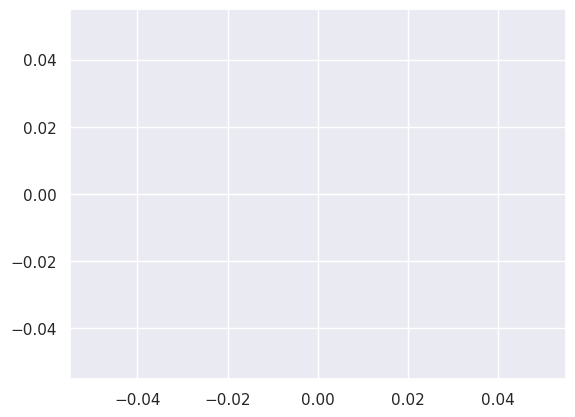

In [15]:
root = osp.join("/home/vision/Repo/cleanset/logs")

iterations_log = None
metrics_info = pd.DataFrame()
for dataset_name in all_datasets:
    metrics_info_path = f'/home/vision/Repo/cleanset/dataset/{dataset_name}/metrics/top_proba.csv'
    dataset_info = pd.read_csv(f"dataset/{dataset_name}/info.csv")
    dataset_info[dataset_info['phase'] == 'train']
    for model_name in all_models:
        for optim in all_optim:
            for initialization in all_initialization:
                for lr_scheduler in all_lr_scheduler:
                    for noise_injection in all_noise_injection[1:]:
                        for noise_sparsity in all_noise_sparsity:
                            for lr_rate in all_lr_rate:
                                for phase in all_phase:
                                    samples_training_data = pd.DataFrame()
                                    for epoch in range(1, all_epochs):
                                        all_fold_loss = []
                                        epoch = f"{epoch :03d}"
                                        for fold in all_folds:
                                            glob_regex = osp.join(root, dataset_name, model_name, optim, initialization, lr_scheduler, f"np={noise_injection}", f"ns={noise_sparsity}", f"lr={lr_rate}", fold, phase, epoch, '*.pd')
                                            iterations_log = sorted(glob.glob(glob_regex))
                                            if len(iterations_log) == 0:
                                                continue
                                            # print("iterations_log: ", iterations_log)
                                            iterations_log = [pd.read_pickle(file_path) for file_path in iterations_log]
                                            iterations_log = pd.concat(iterations_log, axis=0, ignore_index=True)

                                            iterations_log = iterations_log.drop(columns=['loss'])
                                            iterations_log['max proba'] = iterations_log['proba'].apply(lambda x: find_max_proba(x))
                                            iterations_log = iterations_log.drop(columns=['proba'])

                                            iterations_log['phase'] = phase
                                            iterations_log['fold'] = fold
                                            iterations_log['epoch'] = epoch
                                            samples_training_data = samples_training_data._append(iterations_log)
                                    if len(samples_training_data):
                                        proba_stats = samples_training_data.groupby(['sample', 'label'])['max proba'].agg(['mean', 'std']).reset_index()
                                        proba_stats['mean'] = scaler.fit_transform(proba_stats[['mean']])
                                        proba_stats['std'] = scaler.fit_transform(proba_stats[['std']])
                                        merged_df = pd.merge(proba_stats, dataset_info[['index', 'true_label']], left_on='sample', right_on='index', how='inner')

                                        # auc calculation
                                        mean_auc_score = roc_auc_score(y_true = merged_df['true_label'] == merged_df['label'], y_score = merged_df['mean'])
                                        std_auc_score = roc_auc_score(y_true = merged_df['true_label'] == merged_df['label'], y_score = merged_df['std'])
                                        new_row = {'model': model_name, 'optim': optim, 'initialization': initialization, 'lr scheduler': lr_scheduler, 'np': noise_injection, 'ns': noise_sparsity, 'lr rate': lr_rate, 'phase': phase, 'mean auc score ': mean_auc_score, 'std auc score ': std_auc_score}
                                        metrics_info = metrics_info._append(new_row, ignore_index=True)
                                        # end auc calculation


                                        true_label_sample_proba_stats = merged_df[merged_df['label'] == merged_df['true_label']]
                                        wrong_label_sample_proba_stats = merged_df[merged_df['label'] != merged_df['true_label']]
                                        try:
                                            plot_density_2D(
                                                path=osp.join(root, dataset_name, model_name, optim, initialization, lr_scheduler, f"np={noise_injection}", f"ns={noise_sparsity}", f"lr={lr_rate}", f"{phase}_max_proba.png"),
                                                dataframes=[true_label_sample_proba_stats, wrong_label_sample_proba_stats],
                                                target_cols=['mean', 'std'], cmaps=['Greens', 'Reds'], alphas=[1, 0.5],
                                                labels=['true labels', 'wrong labels'],
                                                title=f"Max Proba stats || {dataset_name} {model_name} {optim} {initialization} {lr_scheduler} {phase} | np={noise_injection} ns={noise_sparsity}")
                                        except:
                                            pass
    metrics_info.index.name = 'index'
    metrics_info.to_csv(metrics_info_path)